In [20]:
# SecureString parameter stored in AWS System Manager that holds a GitHub personal access token.
parameter_name = 'github_token'

# Repositories for which reports will be generated.
repo_names = ['aws-amplify/amplify-android', 'aws-amplify/aws-sdk-android']

# Labels used across different repositories
issue_buckets = {'Bug': ['Bug'],
                 'Feature Request': ['Improvement', 'Feature Request'],
                 'Question': ['Usage Question'],
                 'Pending Triage': ['Pending Triage']}

In [23]:
# Retrieve the GitHub token from SSM to prevent oops-I-pushed-credentials-to-GitHub uh-ohs.

import boto3
from github import Github

ssm = boto3.client('ssm')
response = ssm.get_parameter(Name=parameter_name, WithDecryption=True)
token = response['Parameter']['Value']
github = Github(token)

github.get_rate_limit()

RateLimit(core=Rate(remaining=3915, limit=5000))

In [22]:
# Loop through each repository, grab all issues, and create a DataFrame for each.

import pandas as pd

repos = {}
bucket_lookup = {label: bucket for bucket, labels in issue_buckets.items() for label in labels}

for repo_name in repo_names:
    repo = github.get_repo(repo_name)
    issues = []

    for issue in repo.get_issues(state='all'):
        labels = pd.array([label.name for label in issue.labels])
        bucket = 'Other'
        
        for label in labels:
            if label in bucket_lookup:
                bucket = label
                break
                
        if issue.pull_request is None:
            issues.append([issue.number, labels, issue.created_at, issue.closed_at, bucket])
        
    repos[repo_name] = pd.DataFrame(issues, columns=['id', 'labels', 'created_at', 'closed_at', 'bucket'])

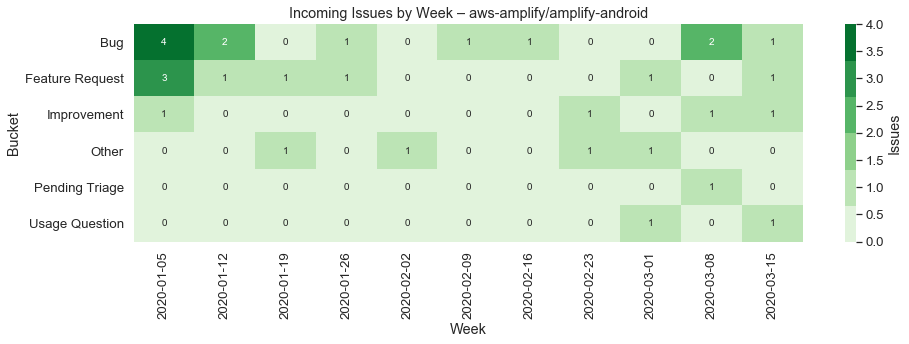

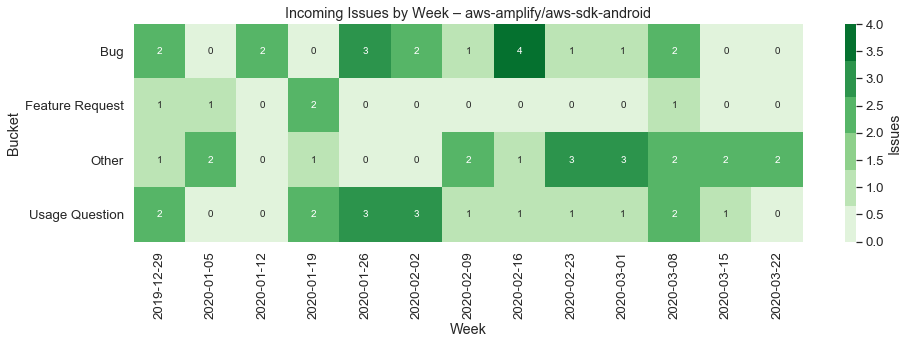

In [24]:
# Incoming Issues by Week

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 4))
    
    df = df.loc[df.created_at > datetime.now() - timedelta(weeks=12)] 
    df = df.pivot(index='created_at', columns='bucket', values='created_at')
    df = df.resample('W').count().transpose()
    dates = df.columns.strftime('%Y-%m-%d').sort_values().unique()

    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Greens"), fmt='d', annot=True,
                     cbar_kws={'label': 'Issues'})
    ax.set(xlabel='Week', ylabel='Bucket', title=f'Incoming Issues by Week – {repo_name}')

    plt.show()

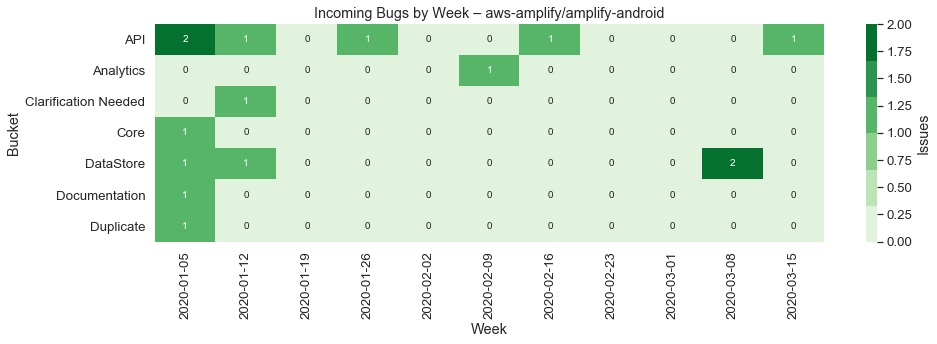

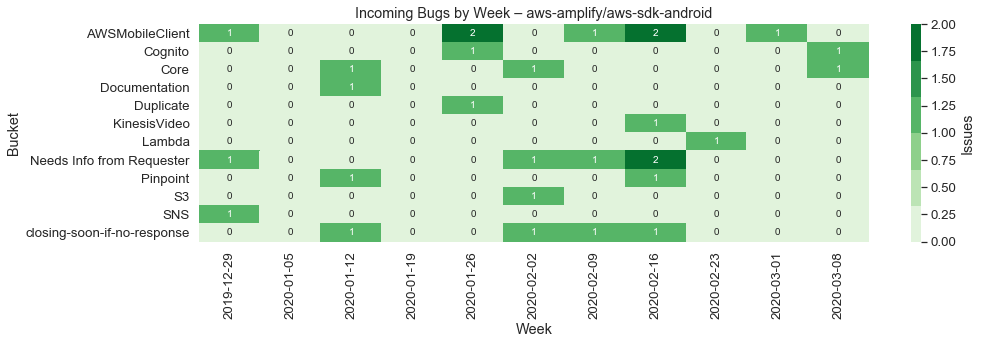

In [28]:
# Incoming Bugs by Week

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 4))
        
    df = df.loc[df.created_at > datetime.now() - timedelta(weeks=12)] 
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'bucket', 'created_at', 'closed_at'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.bucket == 'Bug']
    df = df.pivot(index='created_at', columns='label', values='created_at')
    df = df.resample('W').count().transpose()

    dates = df.columns.strftime('%Y-%m-%d').sort_values().unique()
    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Greens"), fmt='d', annot=True,
                     cbar_kws={'label': 'Issues'})
    ax.set(xlabel='Week', ylabel='Bucket', title=f'Incoming Bugs by Week – {repo_name}')

    plt.show()

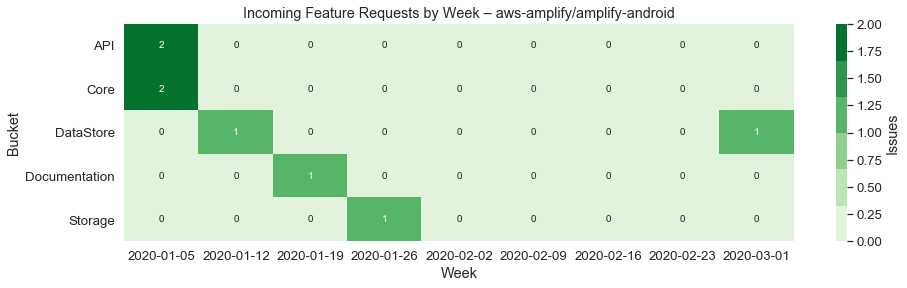

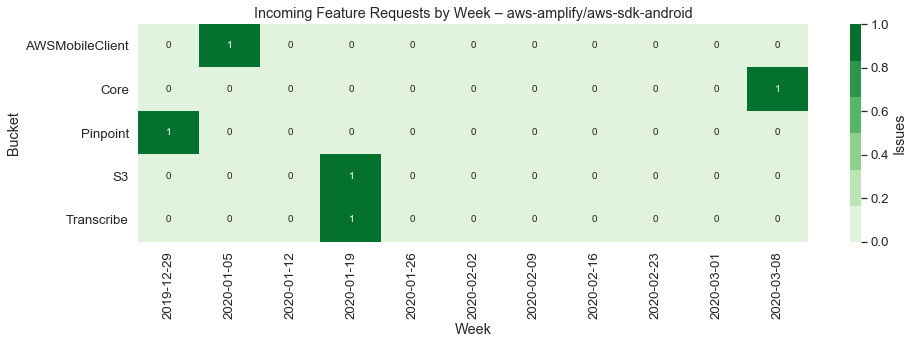

In [26]:
# Incoming Feature Requests by Week

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 4))
        
    df = df.loc[df.created_at > datetime.now() - timedelta(weeks=12)] 
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'bucket', 'created_at', 'closed_at'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.bucket == 'Feature Request']
    df = df.pivot(index='created_at', columns='label', values='created_at')
    df = df.resample('W').count().transpose()

    dates = df.columns.strftime('%Y-%m-%d').sort_values().unique()
    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Greens"), fmt='d', annot=True,
                     cbar_kws={'label': 'Issues'})
    ax.set(xlabel='Week', ylabel='Bucket', title=f'Incoming Feature Requests by Week – {repo_name}')

    plt.show()

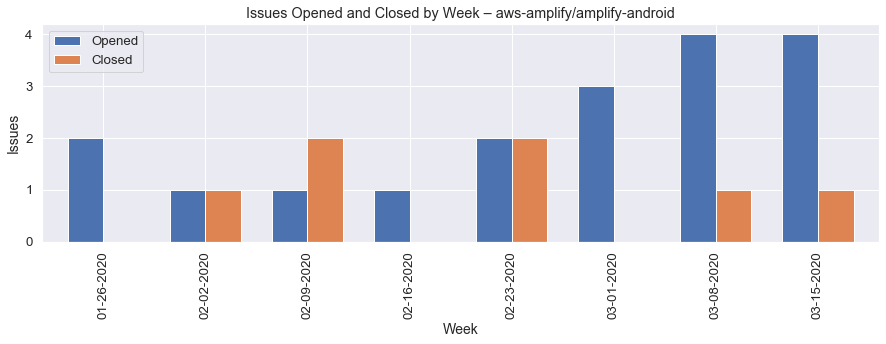

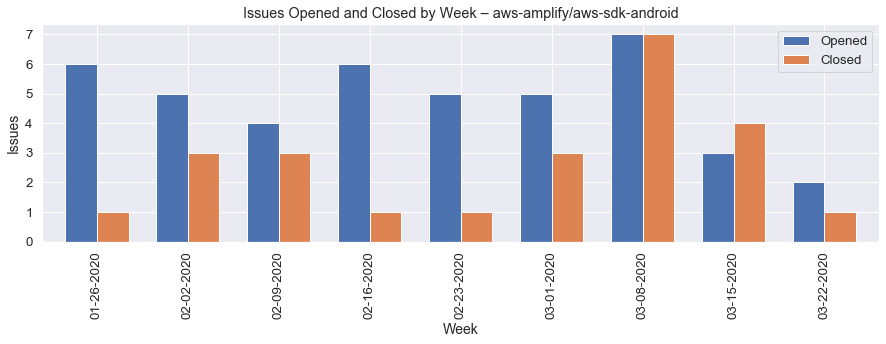

In [27]:
# Issues Opened and Closed by Week

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

%matplotlib inline

for repo_name, df in repos.items():
    df = df.loc[df.created_at > datetime.now() - timedelta(weeks=12)] 
    opened = df.set_index('created_at')
    opened = opened.id.resample('W').count().transpose().to_frame('count')
    closed = df.set_index('closed_at')
    closed = closed.id.resample('W').count().transpose().to_frame('count')
    both = opened.join(closed, how='left', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})
    both = both.loc[both.index > datetime.now() - timedelta(weeks=8)] 

    ax = both[['Opened','Closed']].plot(kind='bar', width=0.7, figsize=(15, 4), legend=True)

    ax.set_xlabel('Week', fontsize=14)
    ax.set_ylabel('Issues', fontsize=14)
    ax.set_xticklabels(both.index.strftime('%m-%d-%Y'))
    ax.set(title=f'Issues Opened and Closed by Week – {repo_name}')
    
    plt.show()